In [18]:
import numpy as num
from scipy import stats
import matplotlib.pyplot as plt
import math as math
import subprocess
from shutil import copyfile
import os

plt.style.use('seaborn-muted')

In [2]:
def genInstancesNormales(ri=2.0, re=4.0, m=30, n=30, iso=500.0, ninst=2, ti=1500.0, te=50.0, 
                 file="./entradas/entrada1.txt", internalNoise=0.1, externalNoise=0.1):
    f = open(file,'w',encoding = 'utf-8')
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)    
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()

In [3]:
def genInstancesPeligrosas(ri=2.0, re=7.0, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entrada1.txt", 
                           internalNoise=0.1, externalNoise=0.1, multDeformacion=1500):
    f = open(file,'w',encoding = 'utf-8')
    
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)
        x = num.linspace(-4,4,n)
        externalTemps += stats.norm.pdf(x, 0, 1)*multDeformacion
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()


In [4]:
def correr(exe='../src/make/tp1', file_in='./entradas/entrada1.txt',
          file_out='./salidas/salida6.txt', method='1'):
    
    subprocess.run('wsl cd /mnt/d/0-Facu/2022-1C-MetNum/tp1/MN2022/tp1/exp; '+exe+' '
                         +file_in+' '+file_out+' '+method)



In [10]:
genInstancesPeligrosas(ri=2.0, re=7.0, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entrada1.txt", 
                           internalNoise=0.1, externalNoise=0.1, multDeformacion=1500)

correr(exe='../src/make/tp1', file_in='./entradas/entrada1.txt',
          file_out='./salidas/salida20.txt', method='1')

temps, isos = getIsotherm(file_in= './entradas/entrada1.txt', file_out='./salidas/salida20.txt', instancias = [0])

In [5]:
def getIsotherm(file_in= './entradas/entrada1.txt', file_out='./salidas/salida1.txt', instancias = [0]):
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
    
    isos = num.empty((len(instancias), n))
    temps = num.empty((len(instancias), m+1, n))
    
    temps_todasLasInstancias= num.loadtxt(file_out).reshape((ninst, m+1, n))
    
    for inst in instancias:

        temp_inst = temps_todasLasInstancias[inst]
        temps[instancias.index(inst)] = temp_inst

        differences = num.abs(temp_inst - iso)
        results = num.empty(n)

        for i in range(0, n):
            column = temp_inst[:,i]
            diffcolumn = differences[:,i]
            closest = diffcolumn.argmin()
            border = True

            if column[closest]<iso:
                if closest > 0:
                    prev = closest - 1
                    pos = closest
                    border = False
                else:
                    iso_radius = ri
            else:
                if closest < m:
                    prev = closest
                    pos = closest + 1
                    border = False
                else:
                    iso_radius = re

            if not border:
                iso_radius = ri + delta_r * (prev + (iso - column[prev])/(column[pos]-column[prev]))

            results[i] = iso_radius
            
        isos[instancias.index(inst)] = results
    
    return temps, isos


In [417]:
def graficar(temps, isos, min_r=2, max_r=7, iso= 500.0):
    (m, n) = temps.shape
    theta = num.linspace(0, 2*num.pi, n)
    
    thetar = num.tile(num.linspace(0, 2*num.pi, n), (m, 1)).transpose()
    r = num.tile(num.linspace(min_r, max_r, m), (n, 1))
    r[:,0] = 0.0
    
    z = temps.transpose()
   
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    dangerBorder = num.full(theta.shape, 1.1*stats.mode(isos)[0][0])
    
    exteriorMode = stats.mode(temps[-1])[0][0]
    interiorMode = stats.mode(temps[0])[0][0]
    
    
    #secondDangerBorder = num.full(theta.shape, min_r + (max_r - min_r)*2*((500.0-100.0)/(1500.0 - 100.0)))
    secondDangerBorder = num.full(theta.shape, min_r + (max_r - min_r)*(1.0/1.325))
    #secondDangerBorder = num.full(theta.shape, min_r + (max_r - min_r)*1.1*((500.0-interiorMode)/(exteriorMode - interiorMode)))
    print(1.1*stats.mode(isos)[0][0])
    print(min_r + (max_r - min_r)*(1/1.325))
    #print(dangerBorder)
    #print(secondDangerBorder)
    
    
    #\frac{max(isoterma_{500^\circ C}(\theta)) - r_i}{r_e - r_i} > 
    #1.5 \times \frac{500^\circ C - moda(T_e(\theta))}{T_i - moda(T_e(\theta))}
    
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.plot(theta, isos, 'k--', label='Isotermia '+ str(iso))
    ax.plot(theta, dangerBorder, 'rx', label='medida de deformación')
    ax.plot(theta, secondDangerBorder, 'kx', label='medida de desplazamiento')
    grafico = ax.pcolor(thetar, r, z, cmap='jet')
    ax.set_rticks([x for x in range(1, math.ceil(max_r), )])
    ax.grid(True)
    ax.set_rmax(max_r)
    ax.legend(loc='upper left')

    fig.colorbar(grafico)
    ax.set_title('Alto horno - Isotermia: ' + str(iso))

    plt.show()


In [418]:
def generarGraficos(exe='../src/make/tp1',
                    file_in='./entradas/entrada1.txt', 
                    file_out='./salidas/salida1.txt', 
                    method='1'):
    
    correr(exe, file_in, file_out, method)

    temps, isos = getIsotherm(file_in, file_out, instancias=[0])
    
    f = open(file_in,'r',encoding = 'utf-8')
    params = num.matrix(f.readline())
    ri = params[0,0]
    re = params[0,1]
    iso = params[0,4]
    f.close()
    
    graficar(temps[0], isos[0], min_r=ri, max_r=re, iso=iso)
    
    return temps, isos
    

5.201355402057608
5.773584905660377


<ipython-input-417-5ea8a28a69c3>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


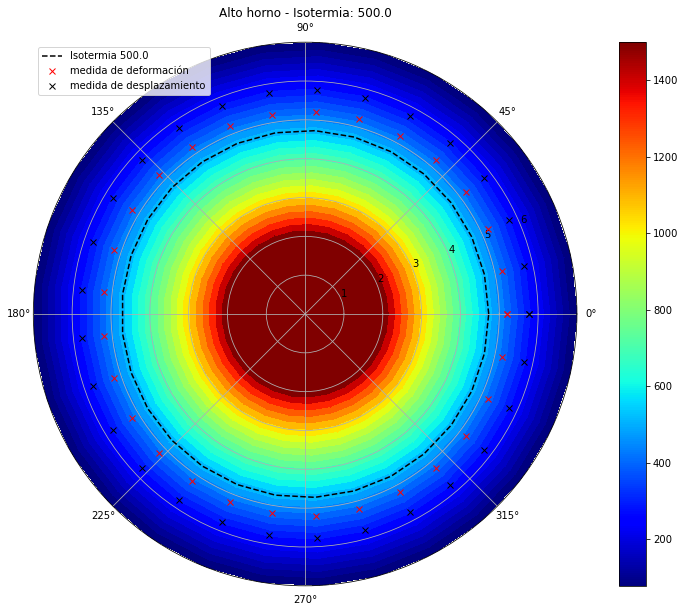

In [419]:
genInstancesNormales(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaNormal.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsSafe, isosSafe = generarGraficos(exe='../src/make/tp1',file_in='./entradas/entradaNormal.txt',
                                      file_out='./salidas/salidaNormal.txt', method='1')

6.861895129652324
5.773584905660377


<ipython-input-417-5ea8a28a69c3>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


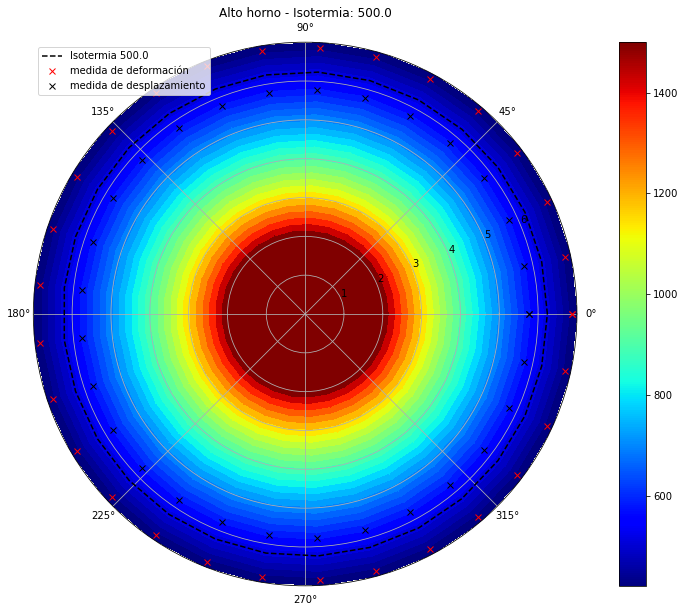

In [421]:
genInstancesNormales(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=400.0, 
                       file='./entradas/entradaNormal.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsNotSafeAllHot, isosNotSafeAllHot = generarGraficos(exe='../src/make/tp1',file_in='./entradas/entradaNormal.txt',
                                      file_out='./salidas/salidaNormal.txt', method='1')

5.209892745646935
5.773584905660377


<ipython-input-417-5ea8a28a69c3>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


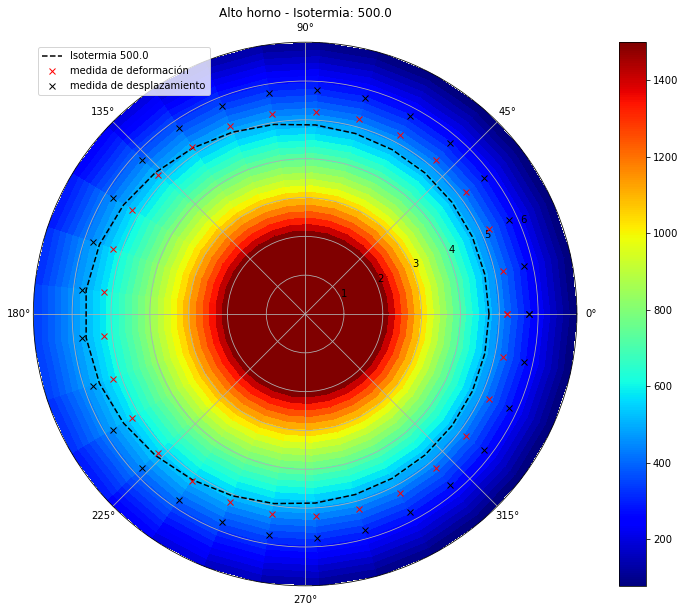

In [422]:
genInstancesPeligrosas(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaPeligrosa.txt', 
                        internalNoise=0.1, externalNoise=0.1, multDeformacion=700)
tempsNotSafe, isosNotSafe = generarGraficos(file_in='./entradas/entradaPeligrosa.txt', 
                                                      file_out='./salidas/salidaPeligrosa.txt', method='1')

In [37]:
print(tempsNotSafe[0,0])

[1500.07 1499.83 1499.99 1499.97 1499.99 1499.75 1500.04 1500.07 1500.
 1499.97 1499.9  1500.07 1500.12 1499.99 1499.91 1499.94 1500.04 1500.06
 1500.2  1500.06 1500.04 1500.1  1499.9  1500.08 1500.02 1500.09 1499.98
 1500.18 1500.05 1499.9 ]


In [9]:
def getIsothermNoSystem(file_in='./entradas/entrada1.txt'):
    
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = re-ri
    
    isos = num.empty(n)
    
    temps = num.matrix(lines[1]).reshape((2, n))
    
   
    for i in range(0, n):
            
        isos[i] = ri + delta_r * (iso - temps[1,i])/(temps[0,i] - temps[1,i])
            
    return temps, isos

3.03433471954979
0.758512127669846


<ipython-input-6-f095a59c0710>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


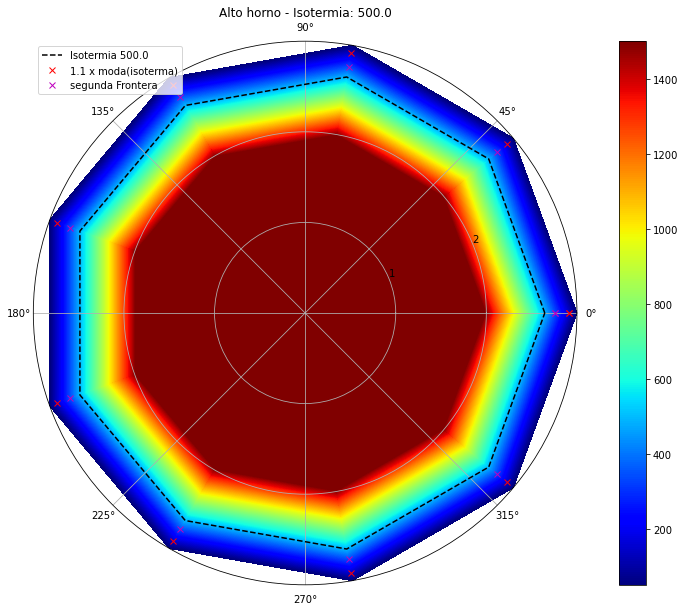

In [11]:
genInstancesNormales(ri=2, re=3, m=1000, n=10, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaPrecisa.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsPreciso, isosPreciso = generarGraficos(exe='../src/make/tp1',file_in='./entradas/entradaPrecisa.txt',
                                      file_out='./salidas/salidaPrecisa.txt', method='1')

In [114]:
print(tempsPreciso.shape)

(1, 1001, 10)


In [518]:
tempsLineal, isosLineal = getIsothermNoSystem(file_in='./entradas/entradaNormal.txt')
print(num.abs(isosSafe - isosLineal))
print(isosSafe)
print(isosLineal)

[[1.17665531 1.1771881  1.17592947 1.17672825 1.1769437  1.17746465
  1.1771413  1.17696352 1.17657694 1.17690553 1.17721305 1.17674864
  1.17645832 1.17718304 1.17705229 1.17694783 1.17745744 1.17696404
  1.17724883 1.17697959 1.17742794 1.17739419 1.17692529 1.1766408
  1.17680865 1.17647855 1.17757017 1.17712942 1.17676253 1.17655553]]
[[4.72854949 4.72856026 4.72850859 4.72856774 4.72864524 4.72872982
  4.72873462 4.72867933 4.72863642 4.72863918 4.72865656 4.72861545
  4.72860573 4.72868243 4.72872411 4.72874926 4.72878203 4.72875595
  4.72876845 4.72878935 4.72883335 4.72880908 4.72869342 4.72862298
  4.72861008 4.72863552 4.72871994 4.72869541 4.72861152 4.72854599]]
[3.55189418 3.55137215 3.55257913 3.55183949 3.55170155 3.55126516
 3.55159332 3.55171581 3.55205948 3.55173365 3.55144351 3.55186682
 3.55214741 3.55149939 3.55167182 3.55180143 3.55132458 3.55179191
 3.55151962 3.55180976 3.55140541 3.55141489 3.55176813 3.55198218
 3.55180143 3.55215697 3.55114977 3.55156598 3.55

In [117]:
genInstancesNormales(ri=0.5, re=0.54, m=60, n=60, iso=0.0, ninst=2, ti=-2.0, te=30.0, 
                 file="./entradas/entradaNE.txt", internalNoise=0.1, externalNoise=0.1)
correr(exe='../src/make/tp1', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaSNE.txt', method='1')
correr(exe='../src/make/tp1NumericErrors', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaNE.txt', method='1')

tempsNE, isoNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaNE.txt', instancias = [0])
tempsSNE, isoSNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaSNE.txt', instancias = [0])

print(tempsSNE - tempsNE)

[[[ 0.  0.  0. ...  0.  0.  0.]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [ 0.  0.  0. ...  0.  0.  0.]]]


In [143]:
def getIsothermBoundary(file_in= './entradas/entradaAntesRefinamiento.txt', 
                        file_out='./salidas/salidaAntesRefinamiento.txt', 
                        new_file_in='./entradas/entradaRefinamiento.txt',
                        new_m=30, instancias = [0], ancho=5):
    
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
    
    #print('\nLineas en getIsothermBound\n')
    #print(lines)
    
    
    temps = num.loadtxt(file_out).reshape((ninst, m+1, n))
    #print(delta_r)

    differences = num.abs(temps[0] - iso)
    bounds = num.empty((n,2))
    isos = num.empty(n)

    for i in range(0, n):
        column = temps[0,:,i]
        diffcolumn = differences[:,i]
        closest = diffcolumn.argmin()
        border = True

        if column[closest]<iso:
            if closest > 0:
                prev = closest - 1
                pos = closest
                border = False
            else:
                prev=closest
                pos=closest
                iso_radius = ri
        else:
            if closest < m:
                prev = closest
                pos = closest + 1
                border = False
            else:
                prev=closest
                pos=closest
                iso_radius = re

        bounds[i,0] = prev
        bounds[i,1] = pos
        
        if not border:
            
            iso_radius = ri + delta_r * (prev + (iso - column[prev])/(column[pos]-column[prev]))
            
        isos[i] = iso_radius

    #innerIndex = int(bounds[:,0].min())
    #outerIndex = int(bounds[:,1].max())

    innerIndex = max(int(bounds[:,0].min()) - ancho, 0)
    outerIndex = min(int(bounds[:,1].max()) + ancho, m)

    
    newRi = ri+innerIndex*delta_r
    newRe = ri+outerIndex*delta_r
    internalTemps = num.ravel(temps[0,innerIndex,:].flatten())
    externalTemps = num.ravel(temps[0,outerIndex,:].flatten())
    
    f = open(new_file_in,'w',encoding = 'utf-8')
    f.write("{0:.6f} {1:.6f} {2:} {3:} {4:.1f} {5:}\n".format(newRi, newRe, new_m+1, n, iso, ninst))
    f.write(' '.join(["{:.6f}".format(elem) for elem in internalTemps]))
    f.write(' ')
    f.write(' '.join(["{:.6f}".format(elem) for elem in externalTemps]))
    f.write('\n')
    f.close()
    
    return temps[0], isos
    

In [144]:
def correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          new_m=30, cantRef=3, ancho=5):
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    
    isos = num.empty((cantRef+1, n))
    temps = {}
    
    correr(exe, file_in, file_out, method)
    
    for ref in range(0, cantRef):
        
        
        temp, iso = getIsothermBoundary(file_in, file_out, new_file_in=file_in, new_m=new_m, instancias = [0], ancho=ancho)
        
        isos[ref] = iso
        temps[ref] = temp
        
        correr(exe, file_in, file_out, method)
    
    temp, iso = getIsotherm(file_in, file_out, instancias = [0])
    
    isos[cantRef] = iso
    temps[cantRef] = temp
    
    return temps, isos
    

In [145]:
genInstancesPeligrosas(ri=200, re=700, m=16, n=30,iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entradaRefinamiento.txt", 
                           internalNoise=0.1, externalNoise=0.1)


In [146]:
temps, isos = correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          new_m=16, cantRef=10)
print(isos.shape)

(11, 30)


In [ ]:
cambio_relativo = num.empty(len(isos)-1)
for i in range(0, len(isos) - 1):
    preRefinamiento = isos[i]
    posRefinamiento = isos[i+1]
    
    cambio_relativo[i] = num.abs(preRefinamiento - posRefinamiento).mean()/preRefinamiento.mean()

print(cambio_relativo)
print(isos)



In [381]:
cambios3 = cambio_relativo


In [25]:
def correrRefinamientoVariosM(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          ms=[3, 6, 12, 24], n=10, cantRef=10):
    
    #cambios_relativos = num.zeros((len(ms), cantRef))
    isos = num.zeros((len(ms), cantRef+1, n))
    
    copyfile(file_in, file_in.replace('.txt','Backup.txt'))
    tempsDict = {}
    
    
    for m in ms:
       
        f = open(file_in.replace('.txt','Backup.txt'),'r',encoding = 'utf-8')
        lines = f.readlines()
        f.close()
        params = num.matrix(lines[0])
        lines[0] = "{0:.1f} {1:.1f} {2:.0f} {3:.0f} {4:.1f} {5:.0f}\n".format(params[0,0],
                                                                              params[0,1],
                                                                              m+1,params[0,3],
                                                                              params[0,4],
                                                                              params[0,5])
        f = open(file_in, 'w',encoding = 'utf-8')
        for line in lines:
            f.writelines(line)
        f.close()
        
        #f = open('./entradas/entradaRefinamiento.txt', 'r',encoding = 'utf-8')
        #print('\nLineas en corrervariosm\n')
        #print(f.readlines())
        #f.close()
        
        
        temps, isosM = correrConRefinamiento(exe='../src/make/tp1', file_in=file_in,
                          file_out=file_out, method=method,
                          new_m=m, cantRef=cantRef)
        
        #cambio_relativo = num.empty(cantRef)
        #for i in range(0, cantRef):
        #    preRefinamiento = isosM[i]
        #    posRefinamiento = isosM[i+1]

        #    cambio_relativo[i] = num.abs(preRefinamiento - posRefinamiento).mean()/preRefinamiento.mean()
        
        #cambios_relativos[ms.index(m)] = cambio_relativo
        isos[ms.index(m)] = isosM
        tempsDict[ms.index(m)] = temps
        
    
    #return cambios_relativos, isos, tempsDict
    return isos, tempsDict
        
    

In [470]:
#genInstancesNormales(ri=200, re=700, m=6, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entradaPreciso.txt", 
#                           internalNoise=0.1, externalNoise=0.1)


In [108]:
isosRefinamiento, tempsRefinamiento = correrRefinamientoVariosM(exe='../src/make/tp1', file_in='./entradas/entradaPrecisa.txt',
                          file_out='./salidas/salidaPrecisaConRefinamiento.txt', method='1',
                          ms=range(3,31), n=10, cantRef=10)
diferencias = num.abs(isosRefinamiento - isosPreciso)

In [101]:
print(tempsRefinamiento[7])

{0: array([[1500.05    , 1500.09    , 1499.88    , 1499.85    , 1500.15    ,
        1499.93    , 1499.96    , 1499.89    , 1500.06    , 1499.94    ],
       [1324.890534, 1324.907868, 1324.728659, 1324.700832, 1324.96754 ,
        1324.774002, 1324.824448, 1324.759028, 1324.878999, 1324.777772],
       [1158.072544, 1158.068872, 1157.916989, 1157.890409, 1158.129746,
        1157.957365, 1158.02935 , 1157.966562, 1158.041221, 1157.955374],
       [ 998.837822,  998.814242,  998.687012,  998.660885,  998.877643,
         998.722023,  998.816552,  998.754852,  998.787818,  998.714749],
       [ 846.52705 ,  846.484223,  846.379593,  846.353222,  846.551327,
         846.408759,  846.526798,  846.464937,  846.458984,  846.396691],
       [ 700.563323,  700.501559,  700.417972,  700.390724,  700.573439,
         700.440735,  700.583242,  700.520189,  700.477432,  700.424371],
       [ 560.438958,  560.358291,  560.294588,  560.265875,  560.435945,
         560.310317,  560.478261,  560.41

In [87]:
diferencias = num.abs(isosRefinamiento - isosPreciso)
print(diferencias[0].shape)

(11, 10)


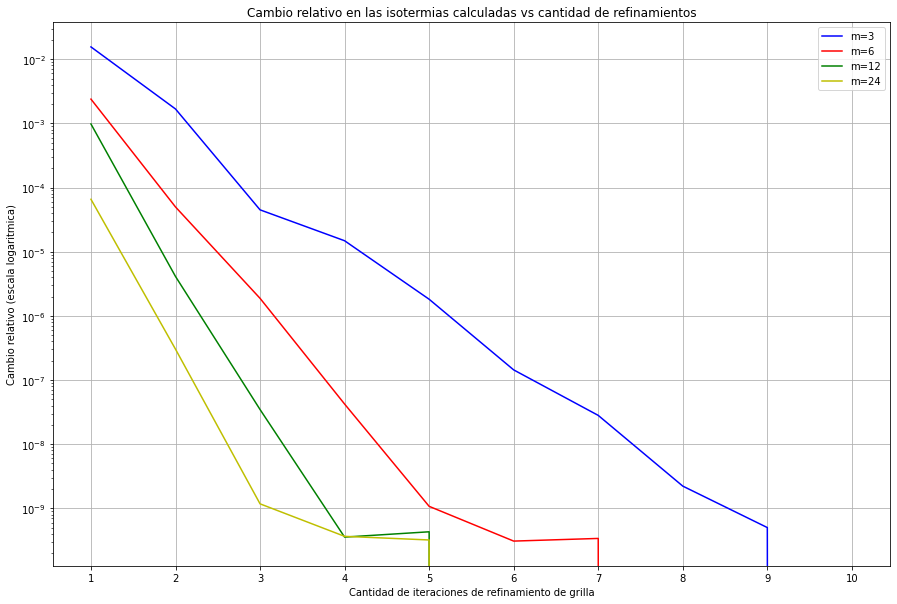

In [473]:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)
ax1.plot(range(1,11), cambios[0], c='b', label='m=3')
ax1.plot(range(1,11), cambios[1], c='r', label='m=6')
ax1.plot(range(1,11), cambios[2], c='g', label='m=12')
ax1.plot(range(1,11), cambios[3], c='y', label='m=24')
ax1.set_yscale('log')
ax1.set_title('Cambio relativo en las isotermias calculadas vs cantidad de refinamientos')
ax1.set_ylabel('Cambio relativo (escala logaritmica)')
ax1.set_xlabel('Cantidad de iteraciones de refinamiento de grilla')
ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()


In [111]:
diferencias[27]

array([[0.00025325, 0.00025337, 0.00025345, 0.00025347, 0.00025328,
        0.00025339, 0.00025317, 0.00025325, 0.0002534 , 0.00025344],
       [0.00026905, 0.000269  , 0.00026899, 0.00026896, 0.00026906,
        0.00026895, 0.00026905, 0.00026901, 0.000269  , 0.00026896],
       [0.0002738 , 0.00027381, 0.00027383, 0.00027382, 0.00027382,
        0.00027379, 0.00027377, 0.00027377, 0.00027382, 0.00027381],
       [0.00027408, 0.00027407, 0.00027408, 0.00027406, 0.0002741 ,
        0.00027403, 0.00027406, 0.00027405, 0.00027407, 0.00027406],
       [0.00027407, 0.00027405, 0.00027405, 0.00027403, 0.00027409,
        0.00027401, 0.00027406, 0.00027404, 0.00027405, 0.00027403],
       [0.00027433, 0.00027432, 0.00027432, 0.0002743 , 0.00027435,
        0.00027428, 0.00027432, 0.0002743 , 0.00027432, 0.0002743 ],
       [0.00027433, 0.00027433, 0.00027435, 0.00027434, 0.00027435,
        0.0002743 , 0.0002743 , 0.0002743 , 0.00027434, 0.00027433],
       [0.00027464, 0.00027464, 0.0002746

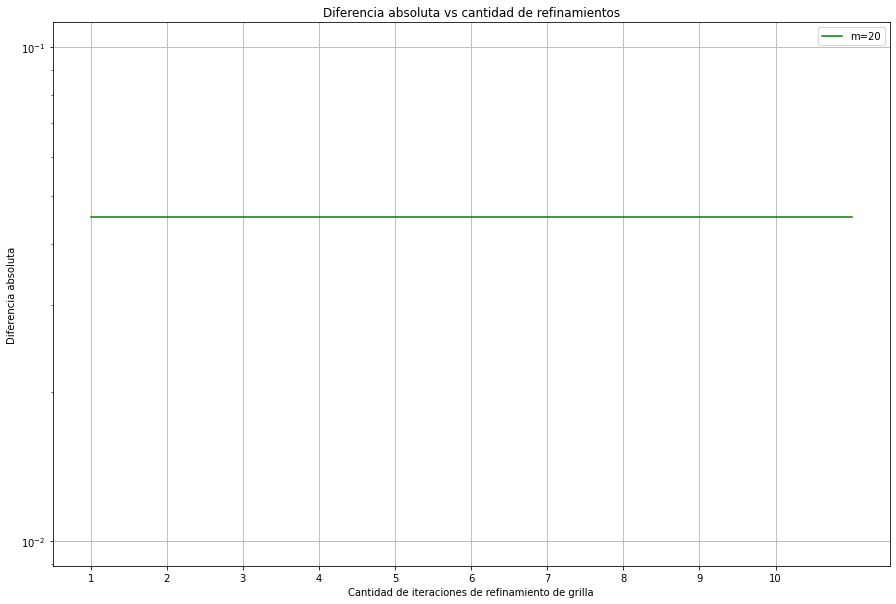

In [65]:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)
#ax1.plot(range(1,12), diferencias[0].mean(axis=1), c='b', label='m=3')
#ax1.plot(range(1,12), diferencias[7].mean(axis=1), c='r', label='m=10')
ax1.plot(range(1,12), diferencias[17].mean(axis=1), c='g', label='m=20')
#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
ax1.set_yscale('log')
ax1.set_title('Diferencia absoluta vs cantidad de refinamientos')
ax1.set_ylabel('Diferencia absoluta')
ax1.set_xlabel('Cantidad de iteraciones de refinamiento de grilla')
ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()


In [425]:
distancia_aOptimo= num.empty(10)

for i in range(0, 10):
    preRefinamiento = isos[3,i]
    

    distancia_aOptimo[i] = num.abs(preRefinamiento - isos[-1,-1]).mean()/preRefinamiento.mean()
        
print(distancia_aOptimo)

[6.55230555e-05 3.14529742e-07 1.18832912e-09 4.27656394e-10
 2.81022214e-10 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [168]:
def tuneoParametrosRefinamiento(isosObjetivo, exe='../src/make/tp1', file_in='./entradas/entradaPrecisaTuneo.txt',
                          file_out='./salidas/salidaTuneo.txt', method='1',
                          ms=[3, 6, 12, 24], anchos=[0,1,2,3,4], n=10, cantRef=10):
    
    #cambios_relativos = num.zeros((len(ms), cantRef))
    diffs = num.zeros((len(ms), len(anchos)))
    
    isos = num.zeros((len(ms), len(anchos), cantRef+1, n))
    
    copyfile(file_in, file_in.replace('.txt','Backup.txt'))
    
    
    for m in ms:
       
        
        
        print(m)
        for ancho in anchos:
            
            f = open(file_in.replace('.txt','Backup.txt'),'r',encoding = 'utf-8')
            lines = f.readlines()
            f.close()
            params = num.matrix(lines[0])
            lines[0] = "{0:.1f} {1:.1f} {2:.0f} {3:.0f} {4:.1f} {5:.0f}\n".format(params[0,0],
                                                                                  params[0,1],
                                                                                  m+1,params[0,3],
                                                                                  params[0,4],
                                                                                  params[0,5])
            f = open(file_in, 'w',encoding = 'utf-8')
            for line in lines:
                f.writelines(line)
            f.close()
            
            print(ancho)
            temps, isosM = correrConRefinamiento(exe=exe, file_in=file_in,
                              file_out=file_out, method=method,
                              new_m=m, cantRef=cantRef, ancho=ancho)
            
            diffs[ms.index(m)][anchos.index(ancho)] = num.abs(isosM[-1] - isosObjetivo).mean()
            isos[ms.index(m)][anchos.index(ancho)] = isosM
        
            print(num.abs(isosM[-1] - isosObjetivo).mean())
            #print(isosM)
        
    
    #return cambios_relativos, isos, tempsDict
    return diffs, isos
        
    

In [192]:
diffs, isosTuneoParametros = tuneoParametrosRefinamiento(isosPreciso, exe='../src/make/tp1', file_in='./entradas/entradaPrecisaTuneo.txt',
                          file_out='./salidas/salidaTuneo.txt', method='1',
                          ms=range(5,71,5), anchos=range(0,11), n=10, cantRef=10)
print(diffs)

5
0
0.001836882025312514
1
0.0015648432470851236
2
0.0007513374239698667
3
0.0005503391651505485
4
0.0005503391651505485
5
0.0005503391651505485
6
0.0005503391651505485
7
0.0005503391651505485
8
0.0005503391651505485
9
0.0005503391651505485
10
0.0005503391651505485
10
0
0.0009189265839800953
1
0.0008687826781851981
2
0.0007976550493512313
3
0.0007223118297659426
4
0.000668384801849653
5
0.0004953147205441155
6
0.000451723202012877
7
0.000451723202012877
8
0.000451723202012877
9
0.000451723202012877
10
0.000451723202012877
15
0
0.0006110439749371199
1
0.000595916046684275
2
0.000566769406242118
3
0.0005346294953611164
4
0.0005023698582002467
5
0.00046751954883581524
6
0.0004356215967643795
7
0.00048160311357552387
8
0.0004801549360439861
9
0.00042485257084523553
10
0.00042485257084523553
20
0
0.0004565648534310629
1
0.0004488282253045206
2
0.0004362474722081178
3
0.0004194163371440407
4
0.0004006677844921036
5
0.000383029936541579
6
0.0003639268619425984
7
0.0003459573130397686
8
0.0003

Text(0.5, 1.0, 'm = 70')

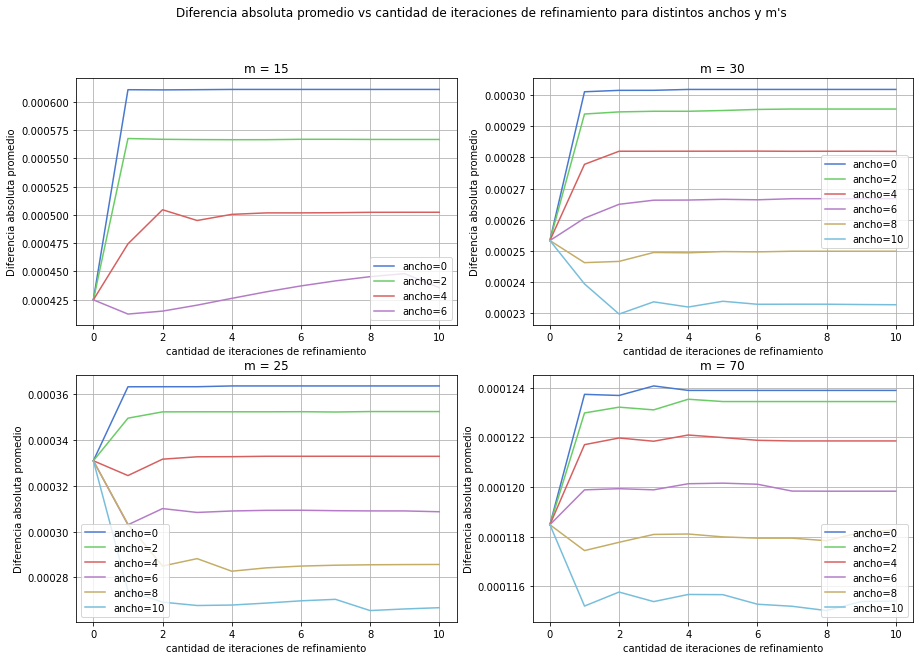

In [256]:
erroresTuneo = num.abs(isosTuneoParametros - isosPreciso)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
fig.suptitle('Diferencia absoluta promedio vs cantidad de iteraciones de refinamiento para distintos anchos y m\'s')
ms = range(5,71,5)

m = 15
for ancho in range(0, 7, 2):
    ax1.plot(range(0,11), erroresTuneo[ms.index(m)][ancho].mean(axis=1), label='ancho='+str(ancho))
ax1.set_ylabel('Diferencia absoluta promedio')
ax1.set_xlabel('cantidad de iteraciones de refinamiento')
ax1.grid(visible=True)
ax1.legend()
ax1.set_title('m = '+str(m))

m = 30
for ancho in range(0, 11, 2):
    ax2.plot(range(0,11), erroresTuneo[ms.index(m)][ancho].mean(axis=1), label='ancho='+str(ancho))
ax2.set_ylabel('Diferencia absoluta promedio')
ax2.set_xlabel('cantidad de iteraciones de refinamiento')
ax2.grid(visible=True)
ax2.legend()    
ax2.set_title('m = '+str(m))

m = 25
for ancho in range(0, 11, 2):
    ax3.plot(range(0,11), erroresTuneo[ms.index(m)][ancho].mean(axis=1), label='ancho='+str(ancho))
ax3.set_ylabel('Diferencia absoluta promedio')
ax3.set_xlabel('cantidad de iteraciones de refinamiento')
ax3.grid(visible=True)
ax3.legend()    
ax3.set_title('m = '+str(m))

m = 70
for ancho in range(0, 11, 2):
    ax4.plot(range(0,11), erroresTuneo[ms.index(m)][ancho].mean(axis=1), label='ancho='+str(ancho))
ax4.set_ylabel('Diferencia absoluta promedio')
ax4.set_xlabel('cantidad de iteraciones de refinamiento')
ax4.grid(visible=True)
ax4.legend()    
ax4.set_title('m = '+str(m))


In [257]:
erroresTuneo[ms.index(25)][10].mean(axis=1)[0]/erroresTuneo[ms.index(25)][10].mean(axis=1)[1]

1.2073305322147865

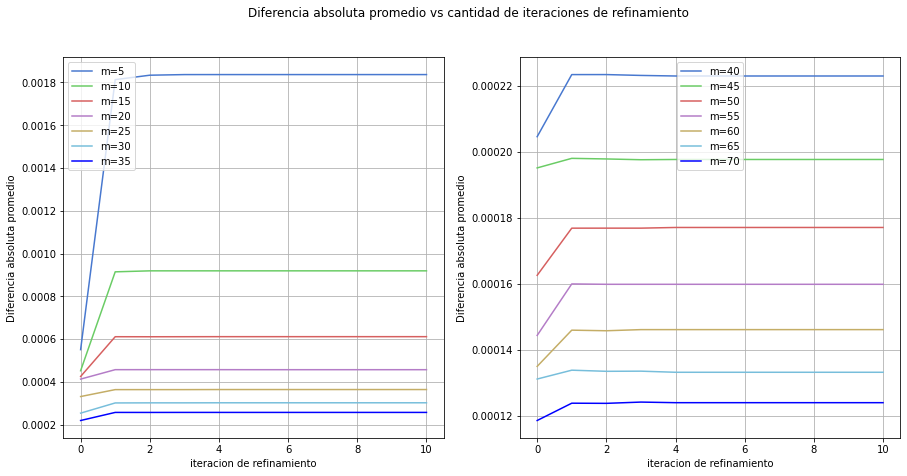

In [227]:
erroresRefinamientoSinAncho = erroresTuneo[:,0,:,:]


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(7)


ms = range(5,31,5)

for m in ms:
    ax1.plot(range(0,11), erroresRefinamientoSinAncho[ms.index(m)].mean(axis=1), label='m='+str(m))
    
ax1.plot(range(0,11), erroresRefinamientoSinAncho[6].mean(axis=1), c='b' ,label='m=35')

#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
#ax1.set_yscale('log')
#ax1.set_title('Diferencia absoluta promedio vs cantidad de iteraciones de refinamiento')
ax1.set_ylabel('Diferencia absoluta promedio')
ax1.set_xlabel('iteracion de refinamiento')
#ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()



ms = range(40,66,5)

for m in ms:
    ax2.plot(range(0,11), erroresRefinamientoSinAncho[ms.index(m)+7].mean(axis=1), label='m='+str(m))
ax2.plot(range(0,11), erroresRefinamientoSinAncho[-1].mean(axis=1), c='b' ,label='m=70')
#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
#ax2.set_yscale('log')
fig.suptitle('Diferencia absoluta promedio vs cantidad de iteraciones de refinamiento')
ax2.set_ylabel('Diferencia absoluta promedio')
ax2.set_xlabel('iteracion de refinamiento')
#ax1.set_xticks(range(1,11,1))
ax2.grid(visible=True)
ax2.legend()

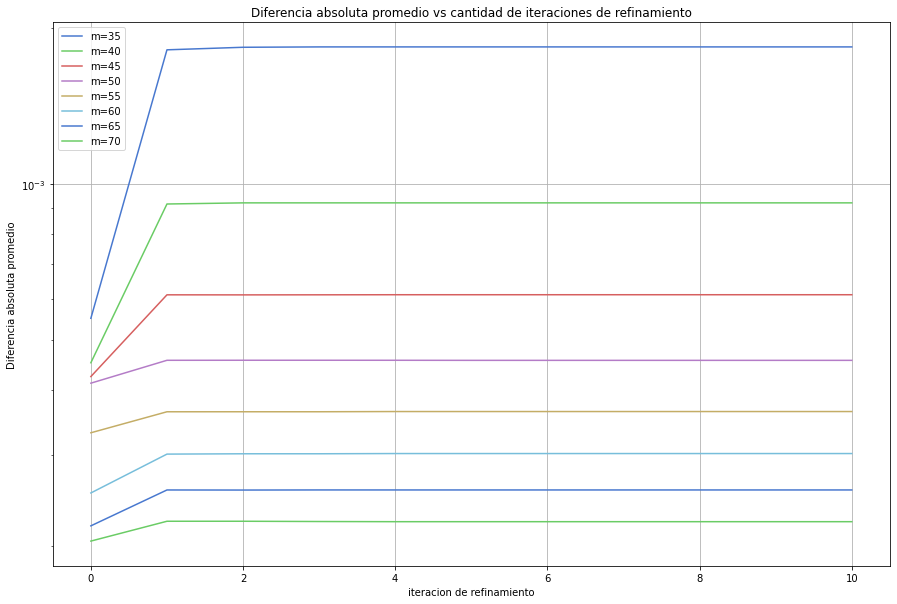

In [220]:
erroresRefinamientoSinAncho = erroresTuneo[:,0,:,:]


fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)


ms = range(35,71,5)

for m in ms:
    ax1.plot(range(0,11), erroresRefinamientoSinAncho[ms.index(m)].mean(axis=1), label='m='+str(m))

#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
ax1.set_yscale('log')
ax1.set_title('Diferencia absoluta promedio vs cantidad de iteraciones de refinamiento')
ax1.set_ylabel('Diferencia absoluta promedio')
ax1.set_xlabel('iteracion de refinamiento')
#ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()

In [ ]:
print(erroresRefinamientoSinAncho)

In [266]:
def tuneoParametrosRefinamientoUnaIt(isosObjetivo, exe='../src/make/tp1', file_in='./entradas/entradaPrecisaTuneo.txt',
                          file_out='./salidas/salidaTuneo.txt', method='1',
                          ms=[3, 6, 12, 24], msSegundo=[3, 6, 12, 24], anchos=[0,1,2,3,4], n=10):
    
    #cambios_relativos = num.zeros((len(ms), cantRef))
    diffs = num.zeros((len(ms), len(anchos), len(msSegundo)))
    
    isos = num.zeros((len(ms), len(anchos), len(msSegundo), 2, n))
    
    copyfile(file_in, file_in.replace('.txt','Backup.txt'))
    
    
    for m in ms:
       
        
        
        print(m)
        for ancho in anchos:
            
            #print(ancho)
            for mNew in msSegundo:
                #print(mNew)
            
                    
                f = open(file_in.replace('.txt','Backup.txt'),'r',encoding = 'utf-8')
                lines = f.readlines()
                f.close()
                params = num.matrix(lines[0])
                lines[0] = "{0:.1f} {1:.1f} {2:.0f} {3:.0f} {4:.1f} {5:.0f}\n".format(params[0,0],
                                                                                      params[0,1],
                                                                                      m+1,params[0,3],
                                                                                      params[0,4],
                                                                                      params[0,5])
                f = open(file_in, 'w',encoding = 'utf-8')
                for line in lines:
                    f.writelines(line)
                f.close()


                temps, isosM = correrConRefinamiento(exe=exe, file_in=file_in,
                                  file_out=file_out, method=method,
                                  new_m=mNew, cantRef=1, ancho=ancho)

                diffs[ms.index(m)][anchos.index(ancho)][msSegundo.index(mNew)] = num.abs(isosM[-1] - isosObjetivo).mean()
                isos[ms.index(m)][anchos.index(ancho)][msSegundo.index(mNew)] = isosM

                #print(num.abs(isosM[-1] - isosObjetivo).mean())
            #print(isosM)
        
    
    #return cambios_relativos, isos, tempsDict
    return diffs, isos
        
    

In [273]:
diffsUnaIt, isosUnaIt = tuneoParametrosRefinamientoUnaIt(isosPreciso, exe='../src/make/tp1', file_in='./entradas/entradaPrecisaTuneo.txt',
                          file_out='./salidas/salidaTuneoUnaIt.txt', method='1',
                          ms=range(3,70,3), msSegundo=range(3,70,3), anchos=range(6,11,2), n=10)

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69


In [312]:
diffsUnaIt = num.abs(isosUnaIt - isosPreciso).mean(axis=4)
mejoras = diffsUnaIt[:,:,:,0]-diffsUnaIt[:,:,:,1]
resultadoFinal = diffsUnaIt[:,:,:,:]

resultadosMasAncho = diffsUnaIt[:,-1,:,:]

indMejora = num.unravel_index(num.argmax(mejoras, axis=None), mejoras.shape)
indMejorResultado = num.unravel_index(num.argmin(resultadoFinal, axis=None), resultadoFinal.shape)
print(indMejora)
print(indMejorResultado)
resultadoFinal[indMejorResultado]


(0, 0, 22)
(22, 0, 0)


4.759098335114231e-05

In [361]:
print(diffsUnaIt[19,0,:,:])

[[1.34899190e-04 7.82811269e-05]
 [1.34899190e-04 1.32897344e-04]
 [1.34899190e-04 1.23834078e-04]
 [1.34899190e-04 1.37053915e-04]
 [1.34899190e-04 1.37411372e-04]
 [1.34899190e-04 1.38442800e-04]
 [1.34899190e-04 1.40522637e-04]
 [1.34899190e-04 1.39137955e-04]
 [1.34899190e-04 1.41551268e-04]
 [1.34899190e-04 1.39555154e-04]
 [1.34899190e-04 1.41547496e-04]
 [1.34899190e-04 1.39833440e-04]
 [1.34899190e-04 1.40700895e-04]
 [1.34899190e-04 1.40032228e-04]
 [1.34899190e-04 1.40264397e-04]
 [1.34899190e-04 1.40181420e-04]
 [1.34899190e-04 1.40035791e-04]
 [1.34899190e-04 1.40297390e-04]
 [1.34899190e-04 1.39919584e-04]
 [1.34899190e-04 1.40390225e-04]
 [1.34899190e-04 1.39867230e-04]
 [1.34899190e-04 1.40265355e-04]
 [1.34899190e-04 1.39852059e-04]]


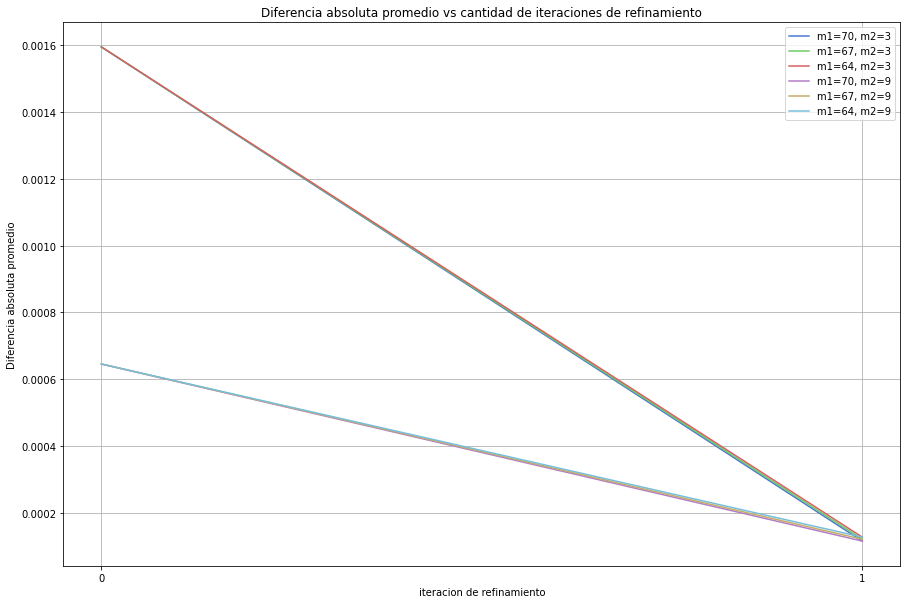

In [369]:
fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)


ms = range(3,70,3)


ax1.plot(range(0,2), diffsUnaIt[0,0,22], label='m1=70, m2=3')
ax1.plot(range(0,2), diffsUnaIt[0,0,21], label='m1=67, m2=3')
ax1.plot(range(0,2), diffsUnaIt[0,0,20], label='m1=64, m2=3')
ax1.plot(range(0,2), diffsUnaIt[2,0,22], label='m1=70, m2=9')
ax1.plot(range(0,2), diffsUnaIt[2,0,21], label='m1=67, m2=9')
ax1.plot(range(0,2), diffsUnaIt[2,0,20], label='m1=64, m2=9')

#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
#ax1.set_yscale('log')
ax1.set_title('Diferencia absoluta promedio vs cantidad de iteraciones de refinamiento')
ax1.set_ylabel('Diferencia absoluta promedio')
ax1.set_xlabel('iteracion de refinamiento')
ax1.set_xticks(range(0,2,1))
ax1.grid(visible=True)
ax1.legend()

In [115]:
def correrVariosM(exe='../src/make/tp1', file_in='./entradas/entradaPrecisaVariosM.txt',
                          file_out='./salidas/salidaVariosM.txt', method='1',
                          ms=[3, 6, 12, 24], n=10):
    
    isos = num.zeros((len(ms), n))
    
    copyfile(file_in, file_in.replace('.txt','Backup.txt'))
    tempsDict = {}
    
    
    for m in ms:
       
        f = open(file_in.replace('.txt','Backup.txt'),'r',encoding = 'utf-8')
        lines = f.readlines()
        f.close()
        params = num.matrix(lines[0])
        lines[0] = "{0:.1f} {1:.1f} {2:.0f} {3:.0f} {4:.1f} {5:.0f}\n".format(params[0,0],
                                                                              params[0,1],
                                                                              m+1,params[0,3],
                                                                              params[0,4],
                                                                              params[0,5])
        f = open(file_in, 'w',encoding = 'utf-8')
        for line in lines:
            f.writelines(line)
        f.close()
        
        #f = open('./entradas/entradaRefinamiento.txt', 'r',encoding = 'utf-8')
        #print('\nLineas en corrervariosm\n')
        #print(f.readlines())
        #f.close()
        correr(exe=exe, file_in=file_in, file_out=file_out, method=method)
        
        temps, isosM = getIsotherm(file_in=file_in, file_out=file_out, instancias = [0])
        
       
        isos[ms.index(m)] = isosM
        tempsDict[ms.index(m)] = temps
        
    
    #return cambios_relativos, isos, tempsDict
    return isos, tempsDict

In [129]:
isosVariosM, tempsVariosM = correrVariosM(ms=range(5,301,5))


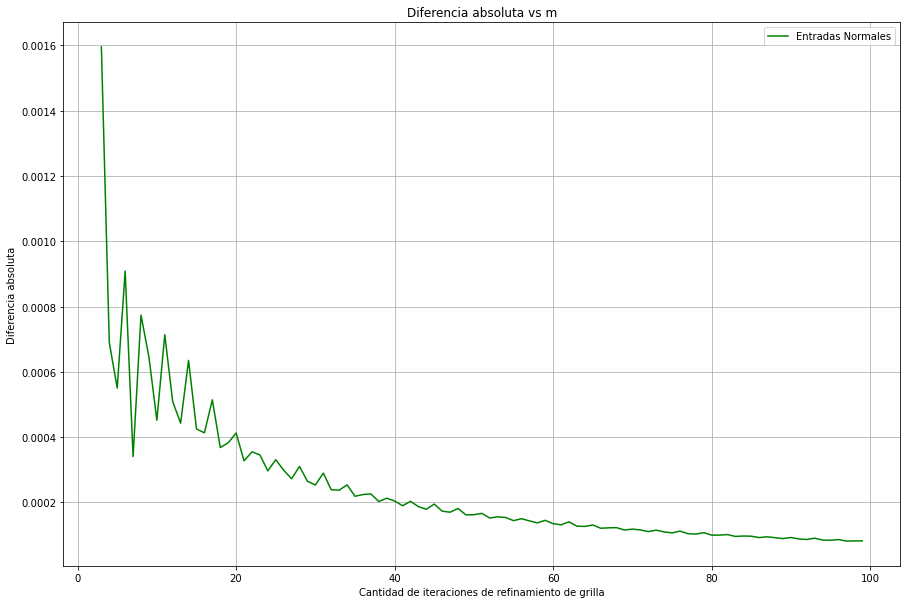

In [127]:
#print(num.abs(isosVariosM - isosPreciso).mean(axis=1))

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)
#ax1.plot(range(1,12), diferencias[0].mean(axis=1), c='b', label='m=3')
#ax1.plot(range(1,12), diferencias[7].mean(axis=1), c='r', label='m=10')
ax1.plot(range(3,100), num.abs(isosVariosM - isosPreciso).mean(axis=1), c='g', label='Entradas Normales')
#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
#ax1.set_yscale('log')
ax1.set_title('Diferencia absoluta vs m')
ax1.set_ylabel('Diferencia absoluta')
ax1.set_xlabel('Cantidad de iteraciones de refinamiento de grilla')
#ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()

In [ ]:
genInstancesPeligrosas(ri=2, re=3, m=1000, n=10, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaPrecisaPeligrosa.txt', 
                        internalNoise=0.1, externalNoise=0.1, multDeformacion=1000)

tempsPrecisoPeligroso, isosPrecisoPeligroso = generarGraficos(exe='../src/make/tp1',file_in='./entradas/entradaPrecisaPeligrosa.txt',
                                      file_out='./salidas/salidaPrecisaPeligrosa.txt', method='1')

isosVariosMPeligroso, tempsVariosMPeligroso = correrVariosM(exe='../src/make/tp1', file_in='./entradas/entradaPrecisaPeligrosa.txt',
                          file_out='./salidas/salidaVariosMPeligrosa.txt', method='1',
                          ms=range(5,301,5), n=10)


In [134]:
isosPrecisoPeligroso.shape



(1, 10)

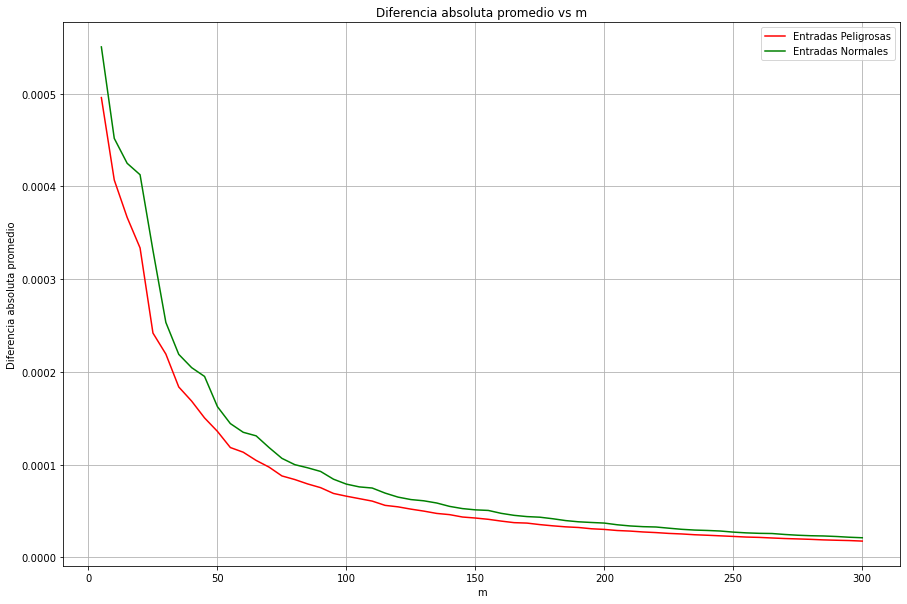

In [137]:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)
#ax1.plot(range(1,12), diferencias[0].mean(axis=1), c='b', label='m=3')
#ax1.plot(range(1,12), diferencias[7].mean(axis=1), c='r', label='m=10')
ax1.plot(range(5,301,5), num.abs(isosVariosMPeligroso - isosPrecisoPeligroso).mean(axis=1), c='r', label='Entradas Peligrosas')
ax1.plot(range(5,301,5), num.abs(isosVariosM - isosPreciso).mean(axis=1), c='g', label='Entradas Normales')

#ax1.plot(range(1,12), diferencias[27].mean(axis=1), c='y', label='m=30')
#ax1.set_yscale('log')
ax1.set_title('Diferencia absoluta promedio vs m')
ax1.set_ylabel('Diferencia absoluta promedio')
ax1.set_xlabel('m')
#ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()

In [207]:
diffs = num.abs(isosVariosM - isosPreciso).mean(axis=1)
oneOverX = num.zeros(diffs.shape)
for i in range(0, len(diffs)):
    oneOverX[i] = (1/(i+3))
    
num.corrcoef(diffs, oneOverX)

array([[1.       , 0.9841227],
       [0.9841227, 1.       ]])

In [210]:
diffsPeligroso = num.abs(isosVariosMPeligroso - isosPrecisoPeligroso).mean(axis=1)
print(isosPrecisoPeligroso.mean())
print(diffsPeligroso[0])
diffsPeligroso[0] / isosPrecisoPeligroso.mean()

2.7200961554050327
0.0004957163304669443


0.00018224220841675732

In [211]:
print(isosPreciso.mean())
print(diffs[0])
diffs[0] / isosPreciso.mean()


2.6452514114809844
0.0005503391651505485


0.00020804796200540827

### Generacion de casos para evaluar la performance en tiempo de los métodos EG vs LU.

In [531]:
# def generateTestFileForEGvsLU():
#     ninst = 1
#     for n in range(10, 50):
#         for m in range(10, 50):
#             archivo='./testEGvsLU/input/file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
#             genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

def generateTestFileForEGvsLU(directory, min_n = 10, max_n = 50, min_m = 10, max_m = 50, min_ninst = 1, max_ninst = 1):
    if not os.path.exists(directory):
        os.mkdir(directory)

    for n in range(min_n, max_n+1):
        for m in range(min_m, max_m+1):
            for ninst in range(min_ninst+9, max_ninst+4, 10):
                archivo= directory + 'file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
                genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

In [532]:
# generateTestFileForEGvsLU('./testEGvsLU/input/')
# test 2
generateTestFileForEGvsLU('./testEGvsLU/input2/', min_n=16, max_n=16, min_m=8, max_m=8, min_ninst=1, max_ninst=500)
# test 3
generateTestFileForEGvsLU('./testEGvsLU/input3/', min_n=16, max_n=16, min_m=16, max_m=16, min_ninst=1, max_ninst=500)
# test 4
generateTestFileForEGvsLU('./testEGvsLU/input4/', min_n=32, max_n=32, min_m=16, max_m=16, min_ninst=1, max_ninst=200)
# test 5
generateTestFileForEGvsLU('./testEGvsLU/input5/', min_n=32, max_n=32, min_m=32, max_m=32, min_ninst=1, max_ninst=200)

### Benchmarks

In [83]:
import subprocess as sp
import os
import json
from datetime import datetime

now = datetime.now()
currentTime = now.strftime("%Y%m%d_%H%M%S")

pathToExe = "../../build/Release/BenchmarkEGvsLU.exe"
repeat = 10

inputFilesDir = './testEGvsLU/input/'
results = []

for filename in os.listdir(inputFilesDir):
    input_file = os.path.join(inputFilesDir, filename)
    if os.path.isfile(input_file) and input_file.endswith(".in"):
        process = sp.Popen([pathToExe, input_file, str(repeat)], stdout=sp.PIPE)
        (output, err) = process.communicate()
        exitCode = process.wait()
        resultStr = output.decode('utf-8')
        results.append(json.loads(resultStr))

outputFilename = './testEGvsLU/results_{:}.json'.format(currentTime)
with open(outputFilename,'w', encoding='utf-8') as outputFile:
    outputFile.write(json.dumps(results, indent=4))


